# Исследование поведения клиентов банка

## Описание проекта

Нам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 
Требуется построить модель, предсказывающую факт расторжения клиентом договора. Целевая метрика - F1-мера (не меньше *0.59*).
Дополнительно необходимо измерять AUC-ROC.
Источник данных: https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling

## Описание данных

Файл ***/datasets/Churn.csv***, в котором содержится таблица со сведениями о клиентах:

Признаки:
- **RowNumber**— индекс строки в данных
- **CustomerId** — уникальный идентификатор клиента
- **Surname** — фамилия
- **CreditScore** — кредитный рейтинг
- **Geography** — страна проживания
- **Gender** — пол
- **Age** — возраст
- **Tenure** — количество недвижимости у клиента
- **Balance** — баланс на счёте
- **NumOfProducts** — количество продуктов банка, используемых клиентом
- **HasCrCard** — наличие кредитной карты
- **IsActiveMember** — активность клиента
- **EstimatedSalary** — предполагаемая зарплата

Целевой признак:

- **Exited** — факт ухода клиента

## Шаг 1. Подготовка данных


Импортируем необходимые модули:

In [3]:
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.preprocessing import OneHotEncoder, RobustScaler                            
from sklearn.utils import resample   

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

R = 10000  

#### Изучение данных
Посмотрим информацию о полученном датасете и выведем для наглядности несколько строк:

In [4]:
bank_churn = pd.read_csv('/datasets/Churn.csv')
display(bank_churn.head(10))
bank_churn.info()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
5,6,15574012,Chu,645,Spain,Male,44,8.0,113755.78,2,1,0,149756.71,1
6,7,15592531,Bartlett,822,France,Male,50,7.0,0.00,2,1,1,10062.80,0
7,8,15656148,Obinna,376,Germany,Female,29,4.0,115046.74,4,1,0,119346.88,1
8,9,15792365,He,501,France,Male,44,4.0,142051.07,2,0,1,74940.50,0
9,10,15592389,H?,684,France,Male,27,2.0,134603.88,1,1,1,71725.73,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             9091 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


В нашей таблице 10000 строк и 14 столбцов, в которых содержатся различные данные о клиентах банка, как категориальные (страна проживания, пол, наличие кредитной карты и т.п.), так и количественные (возраст, предполагаемая зарплата и прочее). Типы данных: целочисленный, вещественный и строковый (object). В столбце **Tenure** присутствуют пропуски значений.

#### Выделение целевого признака
Целевым признаком являются значения столбца **Exited**, в котором отражен факт ухода клиента (*0* - клиент продолжает пользоваться услугами банка, *1* - клиент ушел). Выделим его в отдельную переменную ***target***, а остальные признаки сохраним в переменной ***features***:

In [5]:
features = bank_churn.drop(columns = ['Exited'])
target   = bank_churn['Exited']

#### Отбор признаков
Первые три столбца в таблице ***features*** - идентификационные данные о клиенте (фамилия, ID, порядковый номер записи в таблице). Очевидно, что эта информация никак не коррелирует с поведением клиентов, поэтому в дальнейшем анализе эти столбцы не понадобятся. Удалим их из таблицы:

In [6]:
features.drop(columns = ['RowNumber', 'CustomerId', 'Surname'], inplace = True)
#bank_churn.info()                        #Проверка

#### Заполнение пропусков
Обработаем пропуски в столбце **Tenure** (количество недвижимости у клиента). Рассмотрим несколько записей, у которых отсутствует соответствующее значение:

In [7]:
features.query('Tenure == "NaN"').head(10)

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
30,591,Spain,Female,39,NaN,0.00,3,1,0,140469.38
48,550,Germany,Male,38,NaN,103391.38,1,0,1,90878.13
51,585,Germany,Male,36,NaN,146050.97,2,0,0,86424.57
53,655,Germany,Male,41,NaN,125561.97,1,0,0,164040.94
60,742,Germany,Male,35,NaN,136857.00,1,0,0,84509.57
82,543,France,Female,36,NaN,0.00,2,0,0,26019.59
85,652,Spain,Female,75,NaN,0.00,2,1,1,114675.75
94,730,Spain,Male,42,NaN,0.00,2,0,1,85982.47
99,413,France,Male,34,NaN,0.00,2,0,0,6534.18
111,538,Germany,Male,39,NaN,108055.10,2,1,0,27231.26


При беглом просмотре закономерностей в возникновении пропусков в этом столбце не замечено. Скорее всего, клиенты могли не сообщать банку данную информацию. 

Заполним пропуски медианным значением признака, а также преобразуем его в целочисленный тип:

In [8]:
features['Tenure'].fillna(features['Tenure'].median(),inplace=True)
features['Tenure'] = features['Tenure'].astype('int64')
print(f'Пропусков в столбце "Tenure": {features["Tenure"].isna().sum()}')

Пропусков в столбце "Tenure": 0


#### Кодирование категориальных признаков
Выделим категориальные признаки и произведем их кодирование с помощью функции pd.get_dummies() с параметром drop_first = True:

In [9]:
categorical = ['Geography',
               'Gender']

features = (features.join(pd.get_dummies(features[categorical], drop_first = True))
                    .drop(columns = categorical))
features.sample(5)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
4319,609,34,5,140694.78,2,1,0,46266.63,0,1,1
6690,573,30,5,127406.50,1,1,0,192950.60,1,0,1
231,610,40,0,0.00,2,1,0,62232.60,0,0,1
7590,619,42,8,132796.04,3,1,1,191821.35,1,0,0
7247,582,40,3,110150.43,1,1,1,191757.65,1,0,0


#### Разбиение на выборки и стандартизация признаков
Разделим датасет на обучающую, валидационную и проверочную выборки в соотношении 3:1:1:

In [10]:
tr_and_val_feats, test_feats, tr_and_val_target, test_target = train_test_split(features, target,
                                                                                train_size = 0.8,   # 4:1
                                                                                random_state = R)
train_feats, valid_feats, train_target, valid_target = train_test_split(tr_and_val_feats, 
                                                                        tr_and_val_target,
                                                                        train_size = 0.75,          # 3:1
                                                                        random_state = R)

print(f'''Размеры выборок:

Обучающая \t {train_feats.shape[0]}
Валидационная \t {valid_feats.shape[0]}
Тестовая \t {test_feats.shape[0]}''')

Размеры выборок:

Обучающая 	 6000
Валидационная 	 2000
Тестовая 	 2000


Произведем нормирование количественных признаков:

In [11]:
import warnings                     #Чтобы не выводились предупреждения 
warnings.filterwarnings('ignore')   
   
numeric = ['CreditScore',
           'Age',
           'Tenure',
           'Balance',
           'NumOfProducts',
           'EstimatedSalary']

scaler = RobustScaler().fit(train_feats[numeric].values)
for feats in [train_feats, valid_feats, test_feats]:
    feats.loc[:, numeric] = scaler.transform(feats[numeric].values)
    
display(train_feats.head())

warnings.filterwarnings('default')

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
1809,-0.097744,1.083333,0.25,0.135183,1.0,1,1,-0.486320,0,0,0
2634,0.067669,0.416667,1.00,-0.176535,0.0,1,0,-0.748333,0,1,0
5180,-0.624060,0.500000,0.75,0.495541,1.0,0,1,0.797516,0,1,1
408,0.120301,0.000000,1.25,0.428568,1.0,1,1,0.606551,1,0,1
9640,0.736842,-0.166667,-0.50,-0.764206,0.0,1,0,0.934395,0,0,0


## Выводы

На этом шаге мы изучили полученные данные, произвели их предварительную обработку (заполнение пропусков, нормирование количественных и кодирование категориальных признаков). 

Помимо этого, нами выделен целевой признак (факт ухода клиента из банка), а также сделано разбиение датасета на тренировочную, валидационную и проверочную выборки.

## Шаг 2. Построение моделей классификации

#### Баланс классов целевого признака:

Найдем соотношение размеров классов *0* и *1* целевого признакак **Exited**:

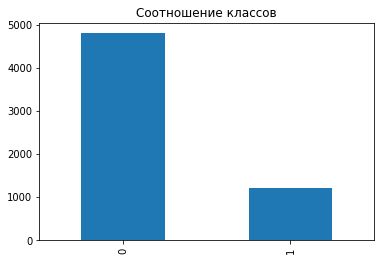

Доля значений 1 - 20.05%
Доля значений 0 - 79.95%


In [12]:
train_target.value_counts().plot(kind = 'bar', title = 'Соотношение классов')
plt.show()
print(f'Доля значений 1 - {train_target.mean():.2%}')
print(f'Доля значений 0 - {1 - train_target.mean():.2%}')

Как можно видеть, классы целевого признака не сбалансированы: значений *0* в 4 раза больше, чем *1*. Изучим, как это скажется на качестве наших моделей.

#### Построение модели без учета дисбаланса классов

Построим несколько моделей классификации и попробуем обучить их, не учитывая пока дисбаланс классов целевой переменной. Рассмотрим следующие алгоритмы:
1. Логистическая регрессия;
2. Метод опорных векторов;
3. Решающее дерево;
4. Случайный лес;

В качестве основной метрики будем использовать F1-меру, в качестве дополнительной - AUC-ROC.

Результаты будем сохранять в таблицу ***results***.

---

### Комментарий наставника

Такой дисбаланс может навредить обучению модели 

---

In [13]:
logreg_model = LogisticRegression(solver = 'saga')                        
SVM_model    = SVC(gamma = 'auto', random_state = R)
tree_model   = DecisionTreeClassifier(random_state = R)
forest_model = RandomForestClassifier(n_estimators = 100, random_state = R)

models_list = [logreg_model, SVM_model, tree_model, forest_model]         #Список моделей для итерирования

results = pd.DataFrame(columns = ['F1', 'AUC ROC'])                       #Пустой датафрейм для результатов

Каждую модель обучим на тренировочных данных, после чего произведем валидацию и найдем F1-меру и площадь под кривой ROC:

In [14]:
def train_and_count_metrics(model, train_feats, train_target):
    '''Обучает модель на заданных тренировочных данных, проводит валидацию и находит F1 и AUC ROC'''
    
    model.fit(train_feats, train_target)
    prediction = model.predict(valid_feats)
    f1 = round(f1_score(valid_target, prediction), 4)
    roc_auc = round(roc_auc_score(valid_target, prediction), 4)
    name = repr(model).split("(")[0]                              #Отображение названия алгоритма
    return name, f1, roc_auc
    
for model in models_list:
    name, f1, roc_auc = train_and_count_metrics(model, train_feats, train_target)
    results.loc[name, 'F1'] = f1
    results.loc[name, 'AUC ROC'] = roc_auc
    
results


,F1,AUC ROC
LogisticRegression,0.3118,0.5875
SVC,0.466,0.6532
DecisionTreeClassifier,0.4848,0.6727
RandomForestClassifier,0.5602,0.7029


Полученные метрики пока что весьма малы, до требуемого значения F1 (*0.59*) ни одна модель не дотянула. Попробуем подстроить гиперпараметры с использованием алгоритма GridSearchCV. Начнем с модели решающего дерева:

In [15]:
tree_parameters = {'max_depth': range(5, 15),
                   'max_features': range(5, 12)}

tree_grid = GridSearchCV(estimator = DecisionTreeClassifier(random_state = R),
                         param_grid = tree_parameters,
                         scoring='f1',
                         cv = 5,
                         verbose = True)

_, f1, roc_auc = train_and_count_metrics(tree_grid, train_feats, train_target)

print(f'Оптимальными параметрами для DecisionTreeClassifier являются {tree_grid.best_params_}')
print(f'Получили F1 = {f1}, AUC ROC = {roc_auc}')
results.loc['DecisionTreeClassifier', 'F1'] = f1
results.loc['DecisionTreeClassifier', 'AUC ROC'] = roc_auc

Fitting 5 folds for each of 70 candidates, totalling 350 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Оптимальными параметрами для DecisionTreeClassifier являются {'max_depth': 8, 'max_features': 11}
Получили F1 = 0.5242, AUC ROC = 0.6863


[Parallel(n_jobs=1)]: Done 350 out of 350 | elapsed:    7.7s finished


Теперь настроим модель случайный лес. Подберем оптимальное значение параметра n_estimators простым перебором:

In [16]:
temp = []
for est in range(100, 251, 10):
    forest_model = RandomForestClassifier(n_estimators = est, 
                                          random_state = R)
    _, f1, roc_auc = train_and_count_metrics(forest_model, train_feats, train_target)
    temp.append([f1, roc_auc, est])

best = max(temp)
print(f'Оптимальное значение n_estimators = {best[2]}, F1 = {best[0]}, ROC AUC = {best[1]}')
results.loc['RandomForestClassifier', 'F1'] = best[0]
results.loc['RandomForestClassifier', 'AUC ROC'] = best[1]

Оптимальное значение n_estimators = 200, F1 = 0.5671, ROC AUC = 0.7062


Также подберем оптимальные параметры для модели на основе опорных векторов:

In [17]:
svc_parameters = {'C': [0.1, 1, 10, 100],
                  'gamma': ['scale', 'auto']}

svm_grid = GridSearchCV(estimator = SVC(random_state = R),
                        param_grid = svc_parameters,
                        scoring='f1',
                        cv = 5,
                        verbose = True)
_, f1, roc_auc = train_and_count_metrics(svm_grid, train_feats, train_target)

print(f'Оптимальными параметрами для SVC являются {svm_grid.best_params_}')
print(f'Получили F1 = {f1}, AUC ROC = {roc_auc}')
results.loc['SVC', 'F1'] = f1
results.loc['SVC', 'AUC ROC'] = roc_auc

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:   48.8s finished


Оптимальными параметрами для SVC являются {'C': 100, 'gamma': 'auto'}
Получили F1 = 0.5109, AUC ROC = 0.6767


In [27]:
results

,F1,AUC ROC,F1 upsampled,AUC ROC upsampled,F1 downsampled,AUC ROC downsampled,F1 c взвешиванием,AUC ROC c взвешиванием
LogisticRegression,0.3118,0.5875,0.5044,0.7047,0.5040,0.7039,0.5053,0.7051
SVC,0.5109,0.6767,0.5745,0.7503,0.5860,0.7646,0.5936,0.7637
DecisionTreeClassifier,0.5242,0.6863,0.5736,0.7518,0.5685,0.7531,0.5770,0.7537
RandomForestClassifier,0.5671,0.7062,0.6055,0.7635,0.6126,0.7843,0.6265,0.7665


## Выводы

Как можно заметить, при наличии даже не очень значительного дисбаланса классов (4:1) исследованные модели не достигают заданной меры F1. Наивысшее значение метрики при этом получилось у модели на основе алгоритма "Случайный лес" (примерно 0.57, AUC ROC при этом равна 0.7)

## Шаг 3. Настройка моделей с учетом дисбаланса классов

Попробуем устранить имеющийся дисбаланс классов одним из следующих способов:
1. Увеличение экземпляров меньшего класса (upsampling);
2. Прореживание большего класса (downsampling);
3. Взвешивание классов.

Сначала создадим модели с оптимальными гиперпараметрами:

In [19]:
logreg_model = LogisticRegression(solver = 'saga')
SVM_model    = SVC(C = 100, 
                   gamma = 'auto', 
                   random_state = R)
tree_model   = DecisionTreeClassifier(max_depth = 8,
                                      random_state = R)
forest_model = RandomForestClassifier(n_estimators = 200,
                                      max_depth = 9,
                                      random_state = R)

models_list = [logreg_model, SVM_model, tree_model, forest_model]           #Обновим список моделей

#### Upsampling
Для того, чтобы увеличить численность меньшего класса (*1*), определим функцию upsample:

In [20]:
def upsample(features, target, repeat):
    '''дублирует случайные записи, относящиеся к меньшему классу'''
    features_zeros = features[target == 0]
    features_ones  = features[target == 1]
    target_zeros   = target[target == 0]
    target_ones    = target[target == 1]
    features_ones_up = resample(features_ones, replace = True, 
                                n_samples = features_zeros.shape[0],
                                random_state = R)
    target_ones_up = resample(target_ones, replace = True, 
                              n_samples = features_zeros.shape[0],
                              random_state = R)
    features_upsampled = pd.concat([features_zeros] + [features_ones_up])
    target_upsampled = pd.concat([target_zeros] + [target_ones_up])
    return features_upsampled, target_upsampled

upsampled_train_feats, upsampled_train_target = upsample(train_feats, train_target, 4)
print(f'Размер обучающей выборки после upsample: {upsampled_train_feats.shape[0]}')
print(f'Доля значений 1 - {upsampled_train_target.mean():.2%}')
print(f'Доля значений 0 - {1 - upsampled_train_target.mean():.2%}')

Размер обучающей выборки после upsample: 9594
Доля значений 1 - 50.00%
Доля значений 0 - 50.00%


Проверим работу моделей:

In [21]:
for model in models_list:
    name, f1, roc_auc = train_and_count_metrics(model, upsampled_train_feats, upsampled_train_target)
    results.loc[name, 'F1 upsampled'] = f1
    results.loc[name, 'AUC ROC upsampled'] = roc_auc
results

,F1,AUC ROC,F1 upsampled,AUC ROC upsampled
LogisticRegression,0.3118,0.5875,0.5044,0.7047
SVC,0.5109,0.6767,0.5745,0.7503
DecisionTreeClassifier,0.5242,0.6863,0.5736,0.7518
RandomForestClassifier,0.5671,0.7062,0.6055,0.7635


#### Downsampling
Теперь наоборот, уменьшим количество экземпляров большего класса:

In [22]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    features_zeros_down = resample(features_zeros, replace = False, 
                                n_samples = features_ones.shape[0],
                                random_state = R)
    target_zeros_down = resample(target_zeros, replace = False, 
                              n_samples = features_ones.shape[0],
                              random_state = R)
    features_downsampled = pd.concat([features_ones] + [features_zeros_down])
    target_downsampled = pd.concat([target_ones] + [target_zeros_down])
    return features_downsampled, target_downsampled

downsampled_train_feats, downsampled_train_target = downsample(train_feats, train_target, 0.25)
print(f'Размер обучающей выборки после downsample: {downsampled_train_feats.shape[0]}')
print(f'Доля значений 1 - {downsampled_train_target.mean():.2%}')
print(f'Доля значений 0 - {1 - downsampled_train_target.mean():.2%}')

Размер обучающей выборки после downsample: 2406
Доля значений 1 - 50.00%
Доля значений 0 - 50.00%


Проверим модели:

In [23]:
for model in models_list:
    name, f1, roc_auc = train_and_count_metrics(model, downsampled_train_feats, downsampled_train_target)
    results.loc[name, 'F1 downsampled'] = f1
    results.loc[name, 'AUC ROC downsampled'] = roc_auc
results

,F1,AUC ROC,F1 upsampled,AUC ROC upsampled,F1 downsampled,AUC ROC downsampled
LogisticRegression,0.3118,0.5875,0.5044,0.7047,0.5040,0.7039
SVC,0.5109,0.6767,0.5745,0.7503,0.5860,0.7646
DecisionTreeClassifier,0.5242,0.6863,0.5736,0.7518,0.5685,0.7531
RandomForestClassifier,0.5671,0.7062,0.6055,0.7635,0.6126,0.7843


#### Взвешивание классов

Наконец, произведем взвешивание классов. Установим для наших моделей параметр class_weight = 'balanced', который будет присваивать каждому классу вес в зависимости от его доли в общем наборе.

Заново обучим модели и рассчитаем метрики:

In [24]:
for model in models_list:
    model.class_weight = 'balanced'
    name, f1, roc_auc = train_and_count_metrics(model, train_feats, train_target)
    results.loc[name, 'F1 c взвешиванием'] = f1
    results.loc[name, 'AUC ROC c взвешиванием'] = roc_auc
    
results

,F1,AUC ROC,F1 upsampled,AUC ROC upsampled,F1 downsampled,AUC ROC downsampled,F1 c взвешиванием,AUC ROC c взвешиванием
LogisticRegression,0.3118,0.5875,0.5044,0.7047,0.5040,0.7039,0.5053,0.7051
SVC,0.5109,0.6767,0.5745,0.7503,0.5860,0.7646,0.5936,0.7637
DecisionTreeClassifier,0.5242,0.6863,0.5736,0.7518,0.5685,0.7531,0.5770,0.7537
RandomForestClassifier,0.5671,0.7062,0.6055,0.7635,0.6126,0.7843,0.6265,0.7665


## Выводы

Как можно видеть, устранение дисбаланса классов значительно улучшило метрики всех моделей. При этом разные модели немного по разному реагировали на upsampling и downsampling, а наиболее эффективным оказалось взвешивание классов.
Данные результаты можно объяснить тем, первые два метода искажают исходные данные (upsampling влияет на распределение признаков, downsampling уменьшает количество информации).

Лучшее значение метрик F1 и AUC ROC показывает модель на основе RandomForestClassifier. На следующем шаге проверим, как она будет работать на тестовом наборе.

## Шаг 4. Проверка модели

Проверим нашу итоговую модель (RandomForestClassifier) на тестовом наборе. Предварительно обучим ее на тренировочных и валидационных выборках, к которым применим upsampling:

In [25]:
tr_and_val_feats = pd.concat([train_feats, valid_feats])
tr_and_val_target = pd.concat([train_target, valid_target])
upd_tr_val_feats, upd_tr_val_target = upsample(tr_and_val_feats, tr_and_val_target, 4)

In [26]:
forest_model.fit(upd_tr_val_feats, upd_tr_val_target)
prediction = forest_model.predict(test_feats)
print(f'Итоговые значения метрик модели RandomForestClassifier:')
print(f'F1-мера = {f1_score(test_target, prediction):.4f},', 
      f'AUC ROC = {roc_auc_score(test_target, prediction):.4f}')


Итоговые значения метрик модели RandomForestClassifier:
F1-мера = 0.6169, AUC ROC = 0.7758


## Итоговый вывод

В данной работе перед нами стояла задача построить модель, которая могла бы прогнозировать расторжение договора клиента с банком на основании различных данных о нем.

Для решения этой задачи нами был исследован датасет, содержащий исторические сведения о клиентах банка. В ходе подготовки данных мы сделали следующие шаги:

1. Произвели предобработку данных: заполнили пропуски и убрали ненужные столбцы ('RowNumber', 'CustomerId', 'Surname'); произвели One-Hot кодирование категориальных признаков и стандартизацию количественных признаков; 
2. Разбили датасет на три подвыборки: тренировочную, валидационную и тестовую - в отношении 3:1:1;
3. Исследовали баланс классов целевого признака и выяснили, что он не сбалансирован - классы 0 и 1 находились в отношении 4 к 1.

Затем мы построили ряд моделей классификации, подобрали для них оптимальные гиперпараметры и посмотрели, как хорошо они работают без учета несбалансированности классов. Полученные значения метрик F1 и AUC ROC показали, что требуется устранить дисбаланс.

Для устранения дисбаланса классов нами были применены следующие методы: upsamling меньшего класса, downsampling большего класса и взвешивание классов. Наилучшие результаты показали модели, обученные с учетом весов классов на тренировочном наборе с апсемплингом. Самое высокое значение целевой метрики F1 было получено на модели "Случайный лес".

Наконец, мы обучили нашу итоговую модель (Случайный лес с параметрами n_estimators = 200, max_depth = 9, class_weight = 'balanced') на совокупности тренировочных и валидационных данных и проверили ее качество на тестовом наборе. В итоге полученное значение F1 метрики составило 0.6169, AUC ROC - 0.7758.